In [1]:
import json, os, re, operator, math, multidict
import os
from tqdm import tqdm_notebook as tqdm
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import paths
from collections import Counter
from Stemmer import Stemmer
stemmer = Stemmer('russian')
from gensim.models.fasttext import FastText

C:\Users\VDanilova\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#from nltk.corpus import stopwords

#stops = stopwords.words('russian')
#print(stops)

In [3]:
def write_in_json(path, data):
    f = open(path, 'w', encoding = 'utf-8')
    json.dump(data, f, indent = 2, ensure_ascii = False)
    f.close()
    

def read_from_json(path):
    with open(path, encoding = 'utf-8') as json_file:  
        data = json.load(json_file)
    return data

### Считываем весь корпус и считаем частотности слов

In [4]:
def load_texts():
    dirs = os.walk('C:\\Users\\VDanilova\\HSE\\ruscorpora')
    texts = []
    for dirr in dirs:    
        path = dirr[0] + '/'
        files = dirr[2]
        for file in tqdm(files):
            text = read_from_json(path + file)
            for t in text:
                for sent in t:
                    texts.append(sent)
    return texts

In [5]:
def count_words(texts):
    ct = Counter()
    for word in texts:
        ct[word] += 1  
    return ct         

In [6]:
#texts = load_texts()

In [7]:
#ct = count_words(texts)
#print (ct.most_common(100)) 

In [8]:
def word_freq_plot(ct):
    freq = {}
    for word in ct.keys():
        number = ct[word]
        if number//50 not in freq.keys():
            freq[number//50] = []
        freq[number//50].append(word)    
    
    x = list(freq.keys())
    x.sort()
    y = []
    x1 = []
    for fr in x:
        if (fr < 1000):
            x1.append(fr)
            y.append(len(freq[fr]))
    print(max(x1))
    print(max(y))
    dpi = 80
    fig = plt.figure(dpi = dpi, figsize = (512*2 / dpi, 384*2 / dpi) )

    plt.plot(x1,y, color = 'blue')

    plt.title('Word frequency')
    plt.ylabel('Number of words')
    plt.xlabel('Number of mentions // 50') 
    
    plt.show()
    fig.savefig('word_freq.png')
    return freq

974
695199


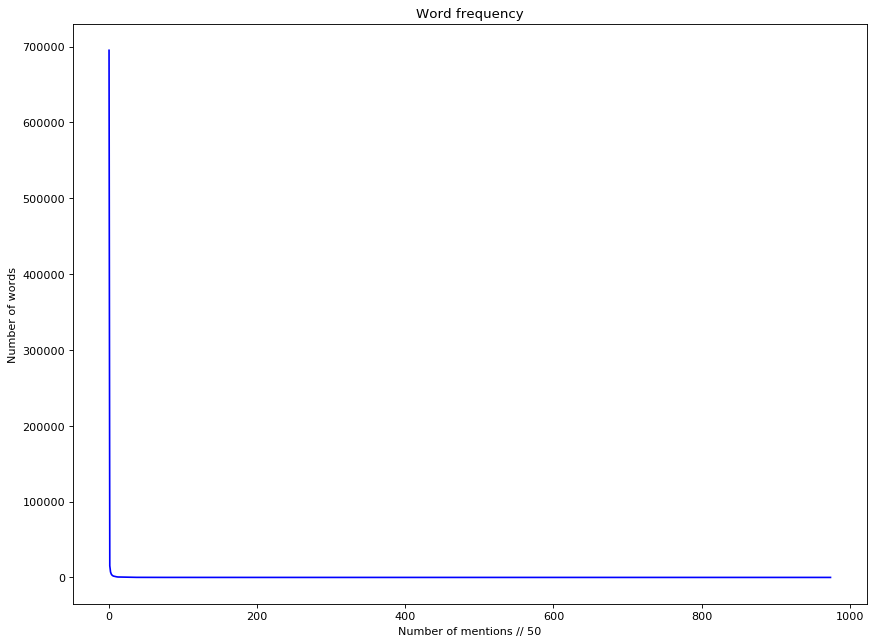

In [139]:
#freq = word_freq_plot(ct)

In [9]:
#x = list(freq.keys())
#x.sort()
#print(len(x))

#### Выписываем слова со средней частотностью

In [6]:
def write_in_txt(name, data):
    with open(name+'.txt', 'w', encoding='utf-8') as f:
        for line in data:
            l = ""
            if type(line) == list:
                for word in line:
                    l += word
                    l += ", "
            else: l = line
            f.write(l+"\n")

In [11]:
#words = []
#for fr in x[250:450]:
#    words.append(freq[fr])
#write_in_txt("words", words)

In [146]:
#str(x[250]*50)+"-"+str(x[450]*50)

'12500-24600'

### Считываем выбранные для тестирования слова и их контексты

In [7]:
def read_words(file):
    res = []
    with open(file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    for line in lines:
        words = line.strip('\n').split(' ')
        for w in words:
            res.append(w)
    return res

In [8]:
test_words = read_words('data/sem_groups.txt')

In [9]:
def load_contexts(words):
    dirs = os.walk(paths._ruscorpora_)
    texts = {}
    for word in words:
        texts[word] = []
    for dirr in dirs:    
        path = dirr[0] + '/'
        files = dirr[2]
        for file in tqdm(files):
            text = read_from_json(path + file)
            for sent in text:
                for w in words:
                    if (w in sent) or (w.replace("е", "ё") in sent):
                        for word in sent:
                            texts[w].append(word)
    return texts

In [10]:
contexts = load_contexts(test_words)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [34]:
for word in contexts.keys():
    print(word + " - " + str(len(contexts[word])))

строительство - 714525
двор - 763115
завод - 700710
автомобиль - 710064
самолет - 643014
стена - 890301
улица - 1474634
дорога - 1439666
площадь - 785881
окно - 1100464
квартира - 1290695
ученый - 821234
специалист - 985512
исследование - 1078274
институт - 1126771
наука - 1129321
школа - 1328283
знание - 715813
технология - 725518
факт - 985552
фирма - 824819
руководитель - 937947
начальник - 874389
договор - 586295
директор - 972428
рабочий - 999005
экономика - 847836
министр - 787955
регион - 814441
гражданин - 927883
политика - 1119327
служба - 1073530
партия - 1076830
федерация - 779435
общественный - 942162
национальный - 945614
мировой - 1092447
экономический - 1104877
социальный - 1116183
федеральный - 883047
музыка - 742581
писатель - 773532
сцена - 821440
спектакль - 679510
картина - 949862
искусство - 963705
фильм - 855345
культура - 1176744
автор - 1453239
театр - 1079531


### Стопслова

In [11]:
STOPS = read_words("data/stopwords.txt")

### Создаем облака слов

In [12]:
def getFrequencyDictForText(sents, w):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}
    mx = 0

    # making dict for counting frequencies
    for word in sents:
        if word not in STOPS and word != w and not have_same_root(w,word) and not word.isdigit():                
            val = tmpDict.get(word,0)
            if val + 1 > mx:
                mx = val + 1
            tmpDict[word] = val+1
    for key in tmpDict:
        fullTermsDict.add(key,tmpDict[key] / (mx*2))
    return fullTermsDict



def Cloud(w, dic):    
    wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
    wc.generate_from_frequencies(dic)
    fig = plt.figure()

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    #plt.show()
    fig.savefig('pic/'+w+'.png') 
    plt.close(fig)
    return wc.words_

In [87]:
for word in contexts.keys():
    sents = contexts[word]
    dic = getFrequencyDictForText(sents, word)
    definition = Cloud(word, dic)
    write_in_txt("cloud_words/"+word, definition)

### Считываем словарные определения слов

In [8]:
dict_definitions = {}
with open("data/definitions.tsv", 'r', encoding='utf-8') as f:
    lines = f.readlines()
for line in lines:
    content = line.strip('\n').split('\t')
    word = content[0]
    if word not in dict_definitions.keys():
        dict_definitions[word] = []
    definitions = content[1].split(';')
    for definition in definitions:
        defin = []
        definition = definition.lower()
        words = re.findall("\w\w+", definition)
        for w in words:
            normal = morph.parse(w)[0].normal_form
            if normal not in defin and normal not in STOPS:
                defin.append(normal)
        dict_definitions[word].append(defin)

In [9]:
dirs = os.walk('cloud_words/tf')
clouds = {}
for dirr in dirs:    
    path = dirr[0] + '/'
    files = dirr[2]
    for file in files:
        text = read_words(path + file)
        clouds[file[0:-4]] = text

In [12]:
dict_definitions_norm = {}
precision = {}
recall = {}
for word in dict_definitions.keys():
    good = 0
    dict_definitions_norm[word] = []
    for definition in dict_definitions[word]:
        for w in definition:
            if w not in dict_definitions_norm[word]:
                dict_definitions_norm[word].append(w)
                if w in clouds[word]:
                    good += 1
    precision[word] = good/len(clouds[word])
    recall[word] = good/len(def_words)
write_in_json("data/precision_pure", precision)
write_in_json("data/recall_pure", recall)

#### Учитываем однокоренные слова

In [13]:
def common_letters(word1, word2):
    n = 0
    i = 0
    for letter in word1:
        if i > len(word2) - 1:
            return n
        if word2[i] == letter:
            n +=1
        else:
            return n
        i += 1
    return n

In [14]:
common_letters("автомобил", "автомобильн")

9

In [15]:
from Levenshtein import distance as lev

In [16]:
def have_same_root(word1, word2):
    w1_stem = stemmer.stemWord(word1)
    w2_stem = stemmer.stemWord(word2)
    if w1_stem == w2_stem or lev(w1_stem, w2_stem) <= 2:
        return True
    comm = common_letters(w1_stem,w2_stem)
    if comm < 4:
        return False
    if comm > 6:
        return True
    diff = abs(len(max(w1_stem,w2_stem))-comm)        
    if diff > comm or diff > 2:
        return False
    return True

In [114]:
with open("data/test_same_root.tsv","w",encoding="utf-8") as f:
    f.write("word1\tword2\tmethod_result\tmanual_result\n")
    for word in dict_definitions.keys():
        for w_dict in dict_definitions_norm[word]:
            for w_cl in clouds[word]:
                res = have_same_root(w_dict, w_cl)
                comm = common_letters(w_dict,w_cl)
                if comm > 2:
                    manual = True
                else:
                    manual = False
                f.write("{0}\t{1}\t{2}\t{3}\n".format(w_dict,w_cl,res,manual))

Нахождение однокоренных слов (не считая приставочного образования):

Точность - 141/151 = 93%

Полнота - 141/181 = 78%

Всего пар - 41304

In [115]:
precision = {}
recall = {}
for word in dict_definitions.keys():
    good = 0
    for w_dict in dict_definitions_norm[word]:
        if w_dict in clouds[word]:
            good += 1
        else:
            for w_cl in clouds[word]:             
                if have_same_root(w_dict, w_cl):                
                    good += 1
                    break
    precision[word] = good/len(clouds[word])
    recall[word] = good/len(def_words)
write_in_json("data/precision_root", precision)
write_in_json("data/recall_root", recall)

### Находим синонимы с помощью fasttext

In [18]:
ft_model = FastText.load('araneum_none_fasttextskipgram_300_5_2018.model')

In [37]:
for word in test_words:
    syn_dic = {}        
    print(word)
    for i in ft_model.wv.most_similar(positive=[word], topn=100):
        neighbour = i[0]
        if re.match(r'[а-я]+$',neighbour) and not have_same_root(neighbour,word) and neighbour not in syn_dic.keys():
            syn_dic[neighbour] = i[1]
    definition = Cloud("syns/"+word, syn_dic)
    write_in_txt("cloud_words/syns/"+word, definition)

строительство


C:\Users\VDanilova\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


двор
завод
автомобиль
самолет
стена
улица
дорога
площадь
окно
квартира
ученый
специалист
исследование
институт
наука
школа
знание
технология
факт
фирма
руководитель
начальник
договор
директор
рабочий
экономика
министр
регион
гражданин
политика
служба
партия
федерация
общественный
национальный
мировой
экономический
социальный
федеральный
музыка
писатель
сцена
спектакль
картина
искусство
фильм
культура
автор
театр


### Tf - Idf

In [40]:
def compute_tf(text):
    tf_text = Counter(text)
    for i in tf_text.keys():
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text


def compute_idf(word, corpus):
    n = 0.0
    for i in corpus.keys():
        if word in corpus[i]:
            n += 1.0
    return math.log10(len(corpus.keys())/n)

 

def compute_tfidf(corpus):
    tf_idf_dic = {}
    for word in corpus.keys():
        tf_idf_one_text = {}
        print(word)
        computed_tf = compute_tf(corpus[word]).most_common(5000)
        print("tf computed!")
        for pair in tqdm(computed_tf):
            tf_idf = pair[1] * compute_idf(pair[0], corpus)
            if tf_idf > 0:
                tf_idf_one_text[pair[0]] = tf_idf
        print("tf-idf computed!")
        tf_idf_dic[word] = tf_idf_one_text
    return tf_idf_dic

In [41]:
tf_idf = compute_tfidf(contexts)
write_in_json('data/tf_idf', tf_idf)

строительство
tf computed!



tf-idf computed!
двор
tf computed!



tf-idf computed!
завод
tf computed!



tf-idf computed!
автомобиль
tf computed!



tf-idf computed!
самолет
tf computed!



tf-idf computed!
стена
tf computed!



tf-idf computed!
улица
tf computed!



tf-idf computed!
дорога
tf computed!



tf-idf computed!
площадь
tf computed!



tf-idf computed!
окно
tf computed!



tf-idf computed!
квартира
tf computed!



tf-idf computed!
ученый
tf computed!



tf-idf computed!
специалист
tf computed!



tf-idf computed!
исследование
tf computed!



tf-idf computed!
институт
tf computed!



tf-idf computed!
наука
tf computed!



tf-idf computed!
школа
tf computed!



tf-idf computed!
знание
tf computed!



tf-idf computed!
технология
tf computed!



tf-idf computed!
факт
tf computed!



tf-idf computed!
фирма
tf computed!



tf-idf computed!
руководитель
tf computed!



tf-idf computed!
начальник
tf computed!



tf-idf computed!
договор
tf computed!



tf-idf computed!
директор
tf computed!



tf-idf computed!
рабочий
tf computed!



tf-idf computed!
экономика
tf computed!



tf-idf computed!
министр
tf computed!



tf-idf computed!
регион
tf computed!



tf-idf computed!
гражданин
tf computed!



tf-idf computed!
политика
tf computed!



tf-idf computed!
служба
tf computed!



tf-idf computed!
партия
tf computed!



tf-idf computed!
федерация
tf computed!



tf-idf computed!
общественный
tf computed!



tf-idf computed!
национальный
tf computed!



tf-idf computed!
мировой
tf computed!



tf-idf computed!
экономический
tf computed!



tf-idf computed!
социальный
tf computed!



tf-idf computed!
федеральный
tf computed!



tf-idf computed!
музыка
tf computed!



tf-idf computed!
писатель
tf computed!



tf-idf computed!
сцена
tf computed!



tf-idf computed!
спектакль
tf computed!



tf-idf computed!
картина
tf computed!



tf-idf computed!
искусство
tf computed!



tf-idf computed!
фильм
tf computed!



tf-idf computed!
культура
tf computed!



tf-idf computed!
автор
tf computed!



tf-idf computed!
театр
tf computed!



tf-idf computed!


In [43]:
sorted_tf_idf = {}
for word in tf_idf.keys():    
    one_sorted_tf_idf = sorted(tf_idf[word].items(), key=operator.itemgetter(1), reverse = True)
    sorted_tf_idf[word] = dict(one_sorted_tf_idf[0:100])
write_in_json('data/sorted_tf_idf', sorted_tf_idf)

#### Облака по tf-idf частотам

In [23]:
sorted_tf_idf = read_from_json('data/sorted_tf_idf')
for word in sorted_tf_idf.keys():    
    definition_tf_idf = Cloud("tf-idf/tf_idf_"+word, sorted_tf_idf[word])
    write_in_txt("cloud_words/tf-idf/tf_idf_"+word, definition_tf_idf)

### Новые слова

In [10]:
def read_json_contexts_id(word_list):
    new_words_id = read_from_json('data/neologisms.json')
    contexts = {}
    for dic in new_words_id:
        forms = dic["list"]
        for w in word_list:
            for f in forms:            
                if have_same_root(w, f):
                    print(w)
                    if w not in contexts.keys():
                        contexts[w] = []
                    for c in dic["contexts"]:
                        if f in c["words"]:
                            oid = c["_id"]["$oid"]
                            if oid not in contexts[w]:
                                contexts[w].append(oid)
                    break
    return contexts

In [11]:
new_words = read_words('data/new_words.txt')
contexts_id_new = read_json_contexts_id(new_words)

волатильность
сверхдоход
кибератака
санкционный
биткоин
майнинг
кибератака
фейковый
майнинг
майнинг
биткоин
фейковый
биткоин
фейковый
гастарбайтер
спорткар
спорткар
притравка
кошмарящий


In [12]:
def read_json_contexts_texts(contexts_id_new):
    new_words_texts = read_from_json('data/contexts.json')
    res_context = {}
    for w in contexts_id_new.keys():
        res_context[w] = []
        print(w)
        for i in contexts_id_new[w]:
            for c in new_words_texts:
                if c["_id"]["$oid"] == i:
                    text = c["context"].lower()
                    words = re.findall("[а-я][а-я]+", text)
                    norms = []
                    for word in words:
                        normal = morph.parse(word)[0].normal_form
                        if normal not in STOPS:
                            norms.append(normal)
                    if norms not in res_context[w]:
                        for n in norms:
                            res_context[w].append(n)
                    break
    return res_context

In [13]:
contexts_new = read_json_contexts_texts(contexts_id_new)

волатильность
сверхдоход
кибератака
санкционный
биткоин
майнинг
фейковый
гастарбайтер
спорткар
притравка
кошмарящий


In [76]:
write_in_json("data/contexts_new.json", contexts_new)

#### Облака для новых слов по tf

In [80]:
for word in contexts_new.keys():
    sents = contexts_new[word]
    dic = getFrequencyDictForText(sents, word)
    definition = Cloud("new/tf/"+word, dic)
    write_in_txt("cloud_words/new/tf/"+word, definition)

#### Облака для новых слов из fasttext

In [39]:
for word in contexts_new.keys():
    sents = contexts_new[word]
    ft_model.build_vocab(sents, update=True)
    ft_model.train(sents, total_examples=ft_model.corpus_count, epochs=ft_model.iter)
    syn_dic = {}        
    print(word)
    for i in ft_model.wv.most_similar(positive=[word], topn=100):
        neighbour = i[0]
        if re.match(r'[а-я]+$',neighbour) and not have_same_root(neighbour,word) and neighbour not in syn_dic.keys():
            syn_dic[neighbour] = i[1]
    definition = Cloud("new/syns/"+word, syn_dic)
    write_in_txt("cloud_words/new/syns/"+word, definition)

C:\Users\VDanilova\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


волатильность
сверхдоход
кибератака
санкционный
биткоин
майнинг
фейковый
гастарбайтер
спорткар
притравка
кошмарящий


### Комбо-облака для новых слов!

In [44]:
for word in contexts_new.keys():
    sents = contexts_new[word]
    context_dic = getFrequencyDictForText(sents, word)        
    print(word)
    for i in ft_model.wv.most_similar(positive=[word], topn=100):
        neighbour = i[0]
        if len(neighbour)> 3 and re.match(r'[а-я]+$',neighbour) and not have_same_root(neighbour,word) and neighbour not in context_dic.keys():
            context_dic.add(neighbour,i[1])
    definition = Cloud("new/combo/"+word, context_dic)
    write_in_json("cloud_words/new/combo/"+word+".json", definition)

волатильность
сверхдоход
кибератака
санкционный
биткоин
майнинг
фейковый
гастарбайтер
спорткар
притравка
кошмарящий


### Комбо-облака для тестовых слов!

In [19]:
for word in test_words:
    sents = contexts[word]
    dic = getFrequencyDictForText(sents, word)        
    print(word)
    for i in ft_model.wv.most_similar(positive=[word], topn=100):
        neighbour = i[0]
        if len(neighbour)> 3 and re.match(r'[а-я]+$',neighbour) and not have_same_root(neighbour,word) and neighbour not in dic.keys():
            dic.add(neighbour,i[1])
    definition = Cloud("combo/"+word, dic)
    write_in_json("cloud_words/combo/"+word+".json", definition)

строительство
двор
завод
автомобиль
самолет
стена
улица
дорога
площадь
окно
квартира
ученый
специалист
исследование
институт
наука
школа
знание
технология
факт
фирма
руководитель
начальник
договор
директор
рабочий
экономика
министр
регион
гражданин
политика
служба
партия
федерация
общественный
национальный
мировой
экономический
социальный
федеральный
музыка
писатель
сцена
спектакль
картина
искусство
фильм
культура
автор
театр
